# Lecture 12: Cool Neural Applications
In this lecture, we'll take a look at some advanced techniques that accomplish cool stuff! I'll also introduce PyTorch, a framework similar to MXNet. Pytorch is more popular than MXNet in the research community, but you'll notice that the syntax is nearly identical to that of Gluon! The point of showing you this new framework is to demonstrate that everything you learned this quarter is applicable outside of mxnet.

## Part 1: Neural Style Transfer

![style](https://cuicaihao.files.wordpress.com/2017/10/unnamed-file.jpg)

Style transfer is a method to make an image appear in the style of a different image, the most common uses are taking a photograph and make it look as if its painted, usually like starry night.

![starry](https://cuicaihao.files.wordpress.com/2017/06/feature-figure.jpg?w=1024)

In this notebook, we implement style transfer that takes a source image and makes it appear to be made of spaghetti noodles.

## Getting Started
Pytorch is the framework that much of MXNet 1.0 is based on. It was one of the first imperative deep learning frameworks and is extremely well supported and documented. Pytorch is meant to be used in a research context and has some trouble compiling on non Linux systems, which is one major area it falls short of MXNet. You'll notice most of the pytorch syntax looks similar to the MXNet examples you're used to. One difference is that Pytorch uses Variables along side standard tensors (mxnet only has tensors). Here, variables just indicate that a gradient graph needs to be created. This is important in Pytorch because unlike MXNet, autograd is __always recording__.

Our strategy for implementing style transfer is to take a pretrained network to extract features from an image. Those features or ideas as we've called them previously, probably contain a lot of information about the style. If our content image and style image are producing similar ideas, they probably look similar! Thus, we'll use the pretrained weights to compare ideas, and then __train the input image__ so that it becomes stylistically similar to the target image. This set up is nice because it means we don't need a dataset, all we need is the pretrained weights, a target image, and a style image.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

Go ahead and load up a few images that we'll use. To start, our style image is spaghetti and our content image is an old man. The goal is to turn the old man into spaghetti.

In [3]:
# desired size of the output image
imsize = 512 if use_cuda else 128  # use small size if no gpu

# pytorch has slightly different syntax for transforms, but this is similar to preprocessing in mxnet
loader = transforms.Compose([
            transforms.Resize(imsize),
            transforms.CenterCrop(imsize),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                 std=[0.229, 0.224, 0.225])
])


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style_img = image_loader("/data/images/picasso.jpg").type(dtype)
content_img = image_loader("/data/images/dancing.jpg").type(dtype)
pasta_img = image_loader("/data/images/pasta.jpg").type(dtype)
face_img = image_loader("/data/images/face.jpg").type(dtype)
starry_img = image_loader("/data/images/starry_night.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

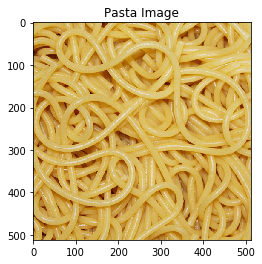

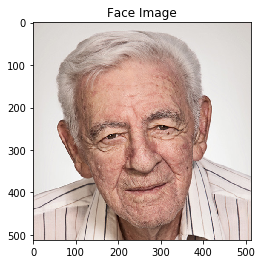

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


#plt.figure()
#imshow(style_img.data, title='Style Image')

#plt.figure()
#imshow(content_img.data, title='Content Image')

plt.figure()
imshow(pasta_img.data, title='Pasta Image')

plt.figure()
imshow(face_img.data, title='Face Image')

#plt.figure()
#imshow(starry_img.data, title='Starry Image')

Our goal is to create a network that makes our content image's style similar to the style images style. We can do that by examining the features. However, we also want to make sure the image still looks like an old man! We thus define two losses, the contentloss is how close to the original image we are while the style loss is how similar are the styles.

In [5]:
# pytorch uses nn.Modules instead of gluon.blocks, it all looks pretty similar though!
# This loss function just checks how similar the current image is to the original
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

The ideas produced by a network actually have some localization effects, for example, one of the ideas might be that theres a dog in the upper right or something. We don't want that local effect, instead we want the entire style to be similar. To delocalize the features, we use whats called a gram matrix. This is computed by multiplying the features with themself transposed. This effectively distributes the local feature throughout the whole matrix.

In [6]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

The style loss is computed similar to the content loss, we have a target style that we can precompute and provide, during training we'll pass in the changin style of our input and try to minimize the stylistic differences.

In [14]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

Load up a pretrained model to extract the features

In [8]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [20]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=(2, 2), stride=(

Now we get to the tricky part, we want to build a model that contains all the losses we're interested in. To do this, we'll start out with a fresh model. Then we'll iterate through our pretrained model and add layers one by one, if we need to compute the loss for one those layers, we'll do so and keep track of that loss.

In [15]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    # iterate through the layer chunks of the model
    i = 1
    for layer in list(cnn):
        # add all convs, keep track of which need losses attached
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)
            # add content losses to the model and keep track of them
            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
            # add style losses to the model and keep track of them
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
        # add activations to the model
        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1
        # add pooling to the model
        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

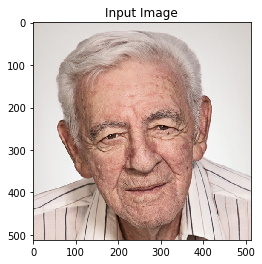

In [16]:
# make a copy of the content image, input_img is what will be changed to look like spaghetti
input_img = face_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')

We need to tell pytorch that we want to optimize the pixels of the input image, we do this by saying the pixels are a __parameter__. Then, we create a trainer that updates only those pixels

In [17]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

Now we're ready to train! Our goal is simply to minimize the style and content loss

In [18]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    # build the model and get the losses
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        # we're using a kind of weird learner (same as in the paper that invented style transfer), it requires the bulk of training to be done in a closure
        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)
            # pass data through the network
            optimizer.zero_grad()
            model(input_param)
            # keep track of total losses
            style_score = 0
            content_score = 0
            # iterate through style losses and compute gradients
            for sl in style_losses:
                style_score += sl.backward()
            # iterate through content losses and compute gradients
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score
        # update the weights!
        optimizer.step(closure)

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 4.870610 Content Loss: 0.020896

run [100]:
Style Loss : 0.609848 Content Loss: 0.024484

run [150]:
Style Loss : 0.251991 Content Loss: 0.024873

run [200]:
Style Loss : 0.053612 Content Loss: 0.026041

run [250]:
Style Loss : 0.017969 Content Loss: 0.026230

run [300]:
Style Loss : 0.009514 Content Loss: 0.025064

run [350]:
Style Loss : 0.006768 Content Loss: 0.023536

run [400]:
Style Loss : 0.005468 Content Loss: 0.022230

run [450]:
Style Loss : 0.004359 Content Loss: 0.021234

run [500]:
Style Loss : 0.003508 Content Loss: 0.020511



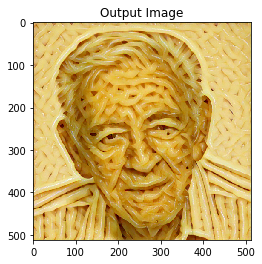

In [19]:
output = run_style_transfer(cnn, face_img, pasta_img, input_img, content_weight=.1, num_steps=500)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()